In [1]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns",25)
pd.set_option("display.max_rows",250)
pd.options.display.float_format = '{:,.2f}'.format

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from urllib.request import urlopen
import json

import random
from patsy import dmatrices
import statsmodels.api as sm

import xgboost as xgb
import plotly.express as px
import shap

#new
# pip install ray
# pip install modin
import ray
import modin.pandas as modin_pd
from modin.utils import to_pandas

import time
from datetime import datetime

In [ ]:
### Basic Ray Core

In [2]:
# First, a basic task - adding up a sum of squares (Ray won't be faster)

t1 = datetime.now()

summation_list = []

for i in range(100):
    summation_list.append(i**2)
    
summation = sum(summation_list)
    
t2 = datetime.now()
print((t2 - t1).microseconds)

998


In [3]:
ray.init(num_cpus = 7) # I have 8 so I'm leaving one behind to handle the basic computer processes

2024-02-27 14:51:06,418	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '172.23.10.22',
 'raylet_ip_address': '172.23.10.22',
 'redis_address': '172.23.10.22:6379',
 'object_store_address': 'tcp://127.0.0.1:64773',
 'raylet_socket_name': 'tcp://127.0.0.1:61066',
 'webui_url': '127.0.0.1:8265',
 'session_dir': 'C:\\Users\\MARCUS~1\\AppData\\Local\\Temp\\ray\\session_2024-02-27_14-51-04_249002_10428',
 'metrics_export_port': 62300,
 'node_id': '1727962aca24ec3128249042fbee2eaf5544f712bf43cbc15fa1bc92'}

In [4]:
t1 = datetime.now()

@ray.remote
def square(x):
    return x**2

futures = [square.remote(i) for i in range(100)]

summation = sum(ray.get(futures))

t2 = datetime.now()
print((t2 - t1).microseconds)

24133


In [ ]:
### Modin csv import

In [5]:
path = 'C:/Users/marcusdeckert/Box/marcusdeckert/Presentation Work/CARFAX Academy/data/'
file = 'data4.csv'

t1 = datetime.now()

x = pd.read_csv(path + file, engine = 'python')

t2 = datetime.now()
print((t2 - t1).microseconds)

326238


In [7]:
path = 'C:/Users/marcusdeckert/Box/marcusdeckert/Presentation Work/CARFAX Academy/data/'
file = 'data4.csv'

t1 = datetime.now()

a = modin_pd.read_csv(path + file)
x = to_pandas(a)

t2 = datetime.now()
print((t2 - t1).microseconds)

7570


In [ ]:
# This difference becomes increasingly larger with larger csv files

In [ ]:
### Okay, let's do a real thing now

In [ ]:
# Lesson 7 GBM 5 Fold CV Lift Chart

In [8]:
### Import data
path = 'C:/Users/marcusdeckert/Box/marcusdeckert/Presentation Work/CARFAX Academy/Lesson 7 stuff/'

data1_train = pd.read_feather(path + 'data1_train')
data1_test = pd.read_feather(path + 'data1_test')

base_score = data1_train['incloss_col'].sum()/data1_train['ee_col'].sum()

drop_cols = ['ee_col','incloss_col','pp']

In [9]:
# Functions from Lesson 7
def easy_gbm(train,test,weights,drop_cols,tweedie_p,bmf,max_depth,base_score,num_round):

    params = {
        'objective': 'reg:tweedie',
        'tweedie_variance_power': tweedie_p,
        'learning_rate': bmf,
        'verbosity': 1,
        'max_depth': max_depth,
        'base_score': base_score
    }

    weight_train = train[weights]
    dtrain = xgb.DMatrix(train.drop(drop_cols, axis=1), label=train['pp'], weight=weight_train)

    global model_xgb
    model_xgb = xgb.train(params, dtrain, num_round)

    weight_test = test[weights]
    dtest = xgb.DMatrix(test.drop(drop_cols, axis=1), label=test['pp'])
    ypred_test = model_xgb.predict(dtest)

    ypred_train = model_xgb.predict(dtrain)

    global out_train, out_test ### sending this output to the global environment so we can use it after the fit
    out_train = train.copy()
    out_train['pred'] = ypred_train
    out_train['pred_loss'] = out_train['pred'] * out_train['ee_col']

    out_test = test.copy()
    out_test['pred'] = ypred_test
    out_test['pred_loss'] = out_test['pred'] * out_test['ee_col']
    
def mad_tt_split_cv_5_folds(data,fold_num):
    np.random.seed(seed=42)
    data['rand'] = np.random.randint(1, 101, data.shape[0])
    
    all_ints = [i for i in range(1, 101)]
    test_ints = [i for i in all_ints if i >= (fold_num-1) * 20 + 1 and i <= fold_num * 20]
    train_ints = [i for i in all_ints if i not in test_ints]
    
    global d1_train, d1_test
    d1_test = data.loc[data['rand'].isin(test_ints)].copy()
    d1_train = data.loc[data['rand'].isin(train_ints)].copy()
    
    del data['rand']

def lift_cv_5_folds(data,tweedie_p,bmf,max_depth,num_round,act, pred, drop_cols, weight_name = 'ee_col', bins = 10):
    x2 = pd.DataFrame()
    for fold in [1,2,3,4,5]:
        mad_tt_split_cv_5_folds(data.copy(),fold)
        
        easy_gbm(d1_train,d1_test,weight_name,drop_cols,tweedie_p,bmf,max_depth,base_score,num_round)
        lift_data = out_test.copy()
    
        lift_data['decile'] = (round(lift_data.sort_values(by = 'pred')[weight_name].cumsum()/lift_data[weight_name].sum(),2)*bins).apply(np.floor)
        lift_data['decile'] = np.where(lift_data['decile'] + 1 > bins ,bins,lift_data['decile'] + 1)
        
        x = lift_data.groupby(['decile'], dropna = False).agg({weight_name: 'sum', act: 'sum', pred: 'sum'}).reset_index()
        x2 = pd.concat([x2,x])
        print('fold ' + str(fold) + ' complete', end = '\r')
    
    dfg = x2.groupby(['decile'], dropna = False).agg({weight_name: 'sum', act: 'sum', pred: 'sum'}).reset_index()
    dfg['pp_act'] = dfg[act]/dfg[weight_name]
    dfg['pp_pred'] = dfg[pred]/dfg[weight_name]
    dfg.drop(columns = [act,pred], inplace = True)
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax2  = ax.twinx()
    
    y_max = np.where(dfg['pp_act'].max() > dfg['pp_pred'].max(),dfg['pp_act'].max(),dfg['pp_pred'].max())*1.20
    ax2.set_ylim(0,y_max)
    
    dfg[weight_name].plot.bar(stacked=False, ax=ax, alpha=0.6)
    dfg['pp_act'].plot(kind='line', ax=ax2, marker='o', linewidth = 0, legend='pp_act')
    dfg['pp_pred'].plot(kind='line', ax=ax2, marker='o', legend='pp_pred')
    plt.show()
    print(dfg[(['decile',weight_name,'pp_act','pp_pred'])])

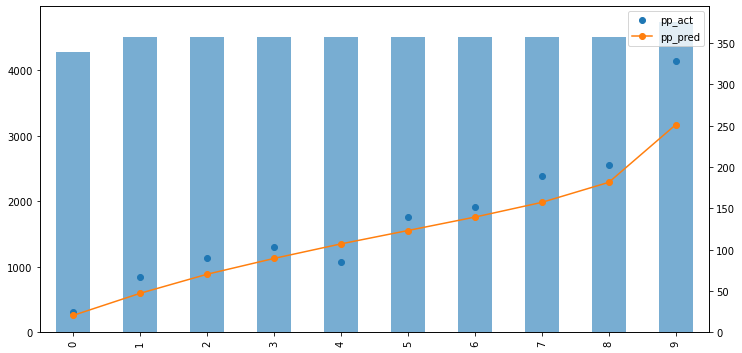

   decile   ee_col  pp_act  pp_pred
0    1.00 4,281.60   25.11    20.63
1    2.00 4,510.96   66.47    47.31
2    3.00 4,508.70   89.74    70.35
3    4.00 4,508.87  102.76    89.48
4    5.00 4,510.58   85.30   107.06
5    6.00 4,508.76  139.97   123.22
6    7.00 4,509.33  151.91   139.45
7    8.00 4,509.04  189.72   157.26
8    9.00 4,509.91  202.00   181.50
9   10.00 4,736.46  328.60   251.22
Time = 3 seconds


In [14]:
t1 = datetime.now()

lift_cv_5_folds(data1_train, 1.5, .05, 4, 50, 'incloss_col', 'pred_loss', drop_cols, weight_name = 'ee_col', bins = 10)

t2 = datetime.now()
print('Time = ' + str((t2 - t1).seconds) + ' seconds')

In [ ]:
### Now, let's use Ray

In [11]:
### Original but with comments
def lift_cv_5_folds(data,tweedie_p,bmf,max_depth,num_round,act, pred, drop_cols, weight_name = 'ee_col', bins = 10):
    
    x2 = pd.DataFrame() # We don't need this anymore
    
    ### This part we need to make each model fit result in the dataframe of the lift data
    for fold in [1,2,3,4,5]:
        mad_tt_split_cv_5_folds(data.copy(),fold)
        
        easy_gbm(d1_train,d1_test,weight_name,drop_cols,tweedie_p,bmf,max_depth,base_score,num_round)
        lift_data = out_test.copy()
    
        lift_data['decile'] = (round(lift_data.sort_values(by = 'pred')[weight_name].cumsum()/lift_data[weight_name].sum(),2)*bins).apply(np.floor)
        lift_data['decile'] = np.where(lift_data['decile'] + 1 > bins ,bins,lift_data['decile'] + 1)
        
        x = lift_data.groupby(['decile'], dropna = False).agg({weight_name: 'sum', act: 'sum', pred: 'sum'}).reset_index()
        x2 = pd.concat([x2,x])
        print('fold ' + str(fold) + ' complete', end = '\r')
    ### End    
        
    ### We will separate this part - it's just making the chart    
    dfg = x2.groupby(['decile'], dropna = False).agg({weight_name: 'sum', act: 'sum', pred: 'sum'}).reset_index()
    dfg['pp_act'] = dfg[act]/dfg[weight_name]
    dfg['pp_pred'] = dfg[pred]/dfg[weight_name]
    dfg.drop(columns = [act,pred], inplace = True)
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax2  = ax.twinx()
    
    y_max = np.where(dfg['pp_act'].max() > dfg['pp_pred'].max(),dfg['pp_act'].max(),dfg['pp_pred'].max())*1.20
    ax2.set_ylim(0,y_max)
    
    dfg[weight_name].plot.bar(stacked=False, ax=ax, alpha=0.6)
    dfg['pp_act'].plot(kind='line', ax=ax2, marker='o', linewidth = 0, legend='pp_act')
    dfg['pp_pred'].plot(kind='line', ax=ax2, marker='o', legend='pp_pred')
    plt.show()
    print(dfg[(['decile',weight_name,'pp_act','pp_pred'])])

In [12]:
### lift_chart alone
def lift_chart(data, act, pred, weight_name = 'ee_col', bins = 10):
    dfg = data.groupby(['decile'], dropna = False).agg({weight_name: 'sum', act: 'sum', pred: 'sum'}).reset_index()
    dfg['pp_act'] = dfg[act]/dfg[weight_name]
    dfg['pp_pred'] = dfg[pred]/dfg[weight_name]
    dfg.drop(columns = [act,pred], inplace = True)

    fig, ax = plt.subplots(figsize=(12,6))
    ax2  = ax.twinx()

    y_max = np.where(dfg['pp_act'].max() > dfg['pp_pred'].max(),dfg['pp_act'].max(),dfg['pp_pred'].max())*1.20
    ax2.set_ylim(0,y_max)

    dfg[weight_name].plot.bar(stacked=False, ax=ax, alpha=0.6)
    dfg['pp_act'].plot(kind='line', ax=ax2, marker='o', linewidth = 0, legend='pp_act')
    dfg['pp_pred'].plot(kind='line', ax=ax2, marker='o', legend='pp_pred')
    plt.show()
    print(dfg[(['decile',weight_name,'pp_act','pp_pred'])])

2024-02-27 14:57:52,236	WARNING worker.py:1107 -- Warning: The remote function __main__.run_model has size 14704822 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


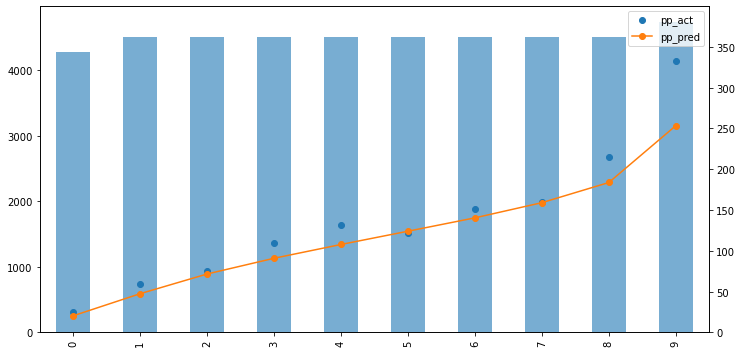

   decile   ee_col  pp_act  pp_pred
0    1.00 4,282.43   24.53    20.39
1    2.00 4,509.84   59.85    47.46
2    3.00 4,509.79   74.84    71.59
3    4.00 4,507.92  109.08    90.88
4    5.00 4,509.63  131.64   107.76
5    6.00 4,510.48  121.98   124.02
6    7.00 4,508.78  150.70   140.39
7    8.00 4,509.71  160.19   158.99
8    9.00 4,508.85  215.50   183.70
9   10.00 4,736.79  333.03   253.35
Time = 4 seconds


In [13]:
t1 = datetime.now()

#Instead of the split function to keep Ray from making 5 duplicate dataframes
data2 = data1_train.copy()
data2['rand'] = np.random.randint(1, 101, data2.shape[0])
data2['fold'] = 5
nxt = data2['rand'] <= 80
data2.loc[nxt,'fold'] = 4
nxt = data2['rand'] <= 60
data2.loc[nxt,'fold'] = 3
nxt = data2['rand'] <= 40
data2.loc[nxt,'fold'] = 2
nxt = data2['rand'] <= 20
data2.loc[nxt,'fold'] = 1

@ray.remote
def run_model(data, fold, tweedie_p, bmf, max_depth, num_round, act, pred, drop_cols, weight_name = 'ee_col', bins = 10):
    easy_gbm(data.loc[data['fold'] != fold],data.loc[data['fold'] == fold],weight_name,drop_cols,tweedie_p,bmf,max_depth,base_score,num_round)
    lift_data = out_test.copy()

    lift_data['decile'] = (round(lift_data.sort_values(by = 'pred')[weight_name].cumsum()/lift_data[weight_name].sum(),2)*bins).apply(np.floor)
    lift_data['decile'] = np.where(lift_data['decile'] + 1 > bins ,bins,lift_data['decile'] + 1)

    x = lift_data.groupby(['decile'], dropna = False).agg({weight_name: 'sum', act: 'sum', pred: 'sum'}).reset_index()
    return x

futures = [run_model.remote(data2, fold + 1, 1.5, .05, 4, 50, 'incloss_col', 'pred_loss', drop_cols, weight_name = 'ee_col') for fold in range(5)] ## This is a list.  You can view them like this: ray.get(futures[0])

x2 = pd.concat(ray.get(futures))

lift_chart(x2, 'incloss_col', 'pred_loss', weight_name = 'ee_col', bins = 10)

t2 = datetime.now()
print('Time = ' + str((t2 - t1).seconds) + ' seconds')

In [ ]:
### What the heck why is it slower?
### It's because this sample data is small...let's triple the size and see what happens

In [15]:
data2_big = pd.DataFrame()
for i in range(3):
    data2_big = pd.concat([data2_big,data2.copy()])
    
data2_big = data2_big.reset_index().drop(columns = ['index']) # GBM will fail with duplicate indexes
    
print(data2.shape)
print(data2_big.shape)

(80134, 59)
(240402, 59)


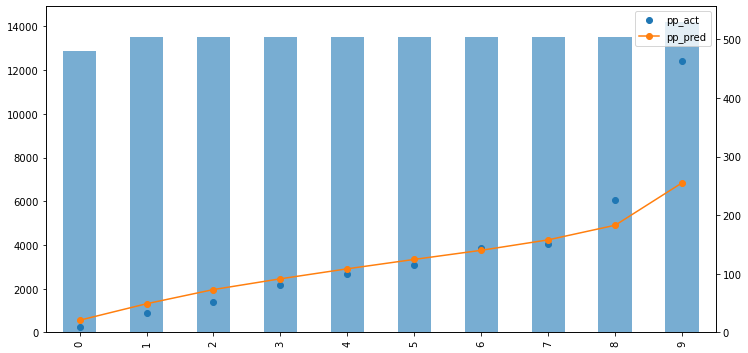

   decile    ee_col  pp_act  pp_pred
0    1.00 12,850.96    8.49    20.79
1    2.00 13,527.86   33.07    48.90
2    3.00 13,528.47   52.62    73.12
3    4.00 13,527.50   80.55    91.48
4    5.00 13,528.00  100.03   108.55
5    6.00 13,528.21  114.83   124.58
6    7.00 13,529.64  144.81   140.10
7    8.00 13,527.73  150.98   157.92
8    9.00 13,526.90  225.04   182.86
9   10.00 14,207.39  463.59   255.30
Time = 10 seconds


In [16]:
t1 = datetime.now()

lift_cv_5_folds(data2_big, 1.5, .05, 4, 50, 'incloss_col', 'pred_loss', drop_cols, weight_name = 'ee_col', bins = 10)

t2 = datetime.now()
print('Time = ' + str((t2 - t1).seconds) + ' seconds')

2024-02-27 14:59:05,767	WARNING worker.py:1107 -- Warning: The remote function __main__.run_model has size 45796672 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.


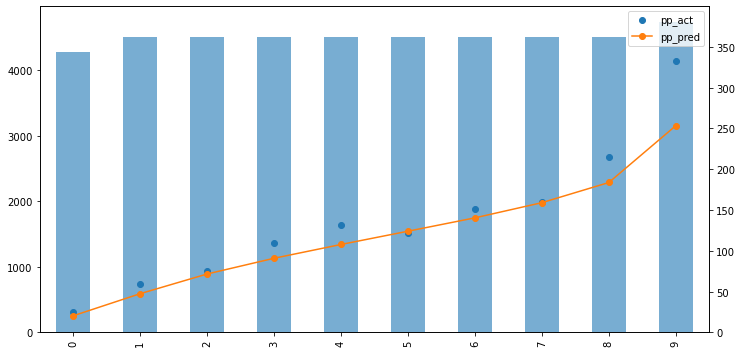

   decile   ee_col  pp_act  pp_pred
0    1.00 4,282.43   24.53    20.39
1    2.00 4,509.84   59.85    47.46
2    3.00 4,509.79   74.84    71.59
3    4.00 4,507.92  109.08    90.88
4    5.00 4,509.63  131.64   107.76
5    6.00 4,510.48  121.98   124.02
6    7.00 4,508.78  150.70   140.39
7    8.00 4,509.71  160.19   158.99
8    9.00 4,508.85  215.50   183.70
9   10.00 4,736.79  333.03   253.35
Time = 3 seconds


In [17]:
t1 = datetime.now()

@ray.remote
def run_model(data, fold, tweedie_p, bmf, max_depth, num_round, act, pred, drop_cols, weight_name = 'ee_col', bins = 10):
    easy_gbm(data.loc[data['fold'] != fold],data.loc[data['fold'] == fold],weight_name,drop_cols,tweedie_p,bmf,max_depth,base_score,num_round)
    lift_data = out_test.copy()

    lift_data['decile'] = (round(lift_data.sort_values(by = 'pred')[weight_name].cumsum()/lift_data[weight_name].sum(),2)*bins).apply(np.floor)
    lift_data['decile'] = np.where(lift_data['decile'] + 1 > bins ,bins,lift_data['decile'] + 1)

    x = lift_data.groupby(['decile'], dropna = False).agg({weight_name: 'sum', act: 'sum', pred: 'sum'}).reset_index()
    return x

futures = [run_model.remote(data2, fold + 1, 1.5, .05, 4, 50, 'incloss_col', 'pred_loss', drop_cols, weight_name = 'ee_col') for fold in range(5)] ## This is a list.  You can view them like this: ray.get(futures[0])

x2 = pd.concat(ray.get(futures))

lift_chart(x2, 'incloss_col', 'pred_loss', weight_name = 'ee_col', bins = 10)

t2 = datetime.now()
print('Time = ' + str((t2 - t1).seconds) + ' seconds')